In [1]:
import dask_awkward as dak
import awkward as ak

In [2]:
taxi = dak.from_parquet("chicago-taxi-dataset")                   # <--- lazy
_taxi = ak.from_parquet("chicago-taxi-dataset", row_groups=[0])   # <--- eager

In [3]:
taxi

dask.awkward<read-parquet, npartitions=25>

In [4]:
taxi.fields

['trip', 'payment', 'company']

In [5]:
taxi.trip.fields

['sec', 'km', 'begin', 'end', 'path']

In [6]:
taxi.layout.form.columns()

['trip.sec',
 'trip.km',
 'trip.begin.lon',
 'trip.begin.lat',
 'trip.begin.time',
 'trip.end.lon',
 'trip.end.lat',
 'trip.end.time',
 'trip.path.londiff',
 'trip.path.latdiff',
 'payment.fare',
 'payment.tips',
 'payment.total',
 'payment.type',
 'company']

In [7]:
_taxi.show(type=True)

type: 353 * var * {
    trip: {
        sec: ?float32,
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        end: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    },
    payment: {
        fare: ?float32,
        tips: ?float32,
        total: ?float32,
        type: categorical[type=string]
    },
    company: categorical[type=string]
}
[[{trip: {sec: 60, km: 0, ...}, payment: {...}, company: ..., ...}, ..., {...}],
 [{trip: {sec: 180, km: 0, ...}, payment: {...}, company: ..., ...}, ...],
 [{trip: {sec: 586, km: 0.966, ...}, payment: {...}, company: ..., ...}, ...],
 [{trip: {sec: 420, km: 1.29, ...}, payment: {...}, company: ..., ...}, ...],
 [{trip: {sec: 0, km: 0, ...}, payment: {...}, company: ..., ...}, ..., {...}],
 [{trip: {sec: 2.64e+03, km:

In [8]:
_taxi[75, -2].tolist()

{'trip': {'sec': 1500.0,
  'km': 0.0,
  'begin': {'lon': -87.66351755,
   'lat': 41.874005383,
   'time': datetime.datetime(2020, 7, 27, 15, 30)},
  'end': {'lon': -87.618677767,
   'lat': 41.835117986,
   'time': datetime.datetime(2020, 7, 27, 16, 0)},
  'path': [{'londiff': 7.550000191258732e-06,
    'latdiff': 8.617000275989994e-06},
   {'londiff': 7.550000191258732e-06, 'latdiff': 0.00012061699817422777},
   {'londiff': 0.011706549674272537, 'latdiff': 0.00031161701190285385},
   {'londiff': 0.016331549733877182, 'latdiff': 0.00028461701003834605},
   {'londiff': 0.01660054922103882, 'latdiff': -0.006792382802814245},
   {'londiff': 0.018389549106359482, 'latdiff': -0.006867383141070604},
   {'londiff': 0.018419550731778145, 'latdiff': -0.007153382990509272},
   {'londiff': 0.018912550061941147, 'latdiff': -0.010070382617413998},
   {'londiff': 0.025673549622297287, 'latdiff': -0.027933383360505104},
   {'londiff': 0.03200655058026314, 'latdiff': -0.032208383083343506},
   {'londif

In [9]:
taxi[0]._meta

<Array-typetracer type='?? * {trip: {sec: ?float32, km: ?float32, begin: {l...'>

In [10]:
all_longitudes = taxi.trip.begin.lon + taxi.trip.path.londiff
all_latitudes = taxi.trip.begin.lat + taxi.trip.path.latdiff

In [11]:
LONGITUDE, LATITUDE = -87.66178, 41.8968   # mean position (center of town)
LON_TO_KM, LAT_TO_KM = 82.98452, 111.0713  # lon, lat → km conversion factors
km_east, km_north = (
    (all_longitudes - LONGITUDE) * LON_TO_KM,
    (all_latitudes - LATITUDE) * LAT_TO_KM,
)

Pseudocode for distance of each trip given the path segments using non-array programming:
```python
for taxi in taxis:
    for trip in in taxi.trips:
        length = 0
        for i in in range(len(trip.paths) - 1):
            Δx = east[i + 1] - east[i]
            Δy = north[i + 1] - north[i]
            Δr = np.sqrt(Δx**2 + Δy**2)
            length += Δr
```

In [12]:
dx = (km_east[:, :, 1:] - km_east[:, :, :-1])
dy = (km_north[:, :, 1:] - km_north[:, :, :-1])
dr = np.sqrt(dx ** 2 + dy ** 2)
lengths = dak.sum(dr, axis=-1)
# lengths = dak.sum(np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 + (km_north[:, :, 1:] - km_north[:, :, :-1])**2), axis=-1)

In [13]:
lengths._meta

<Array-typetracer type='?? * var * ?float64'>

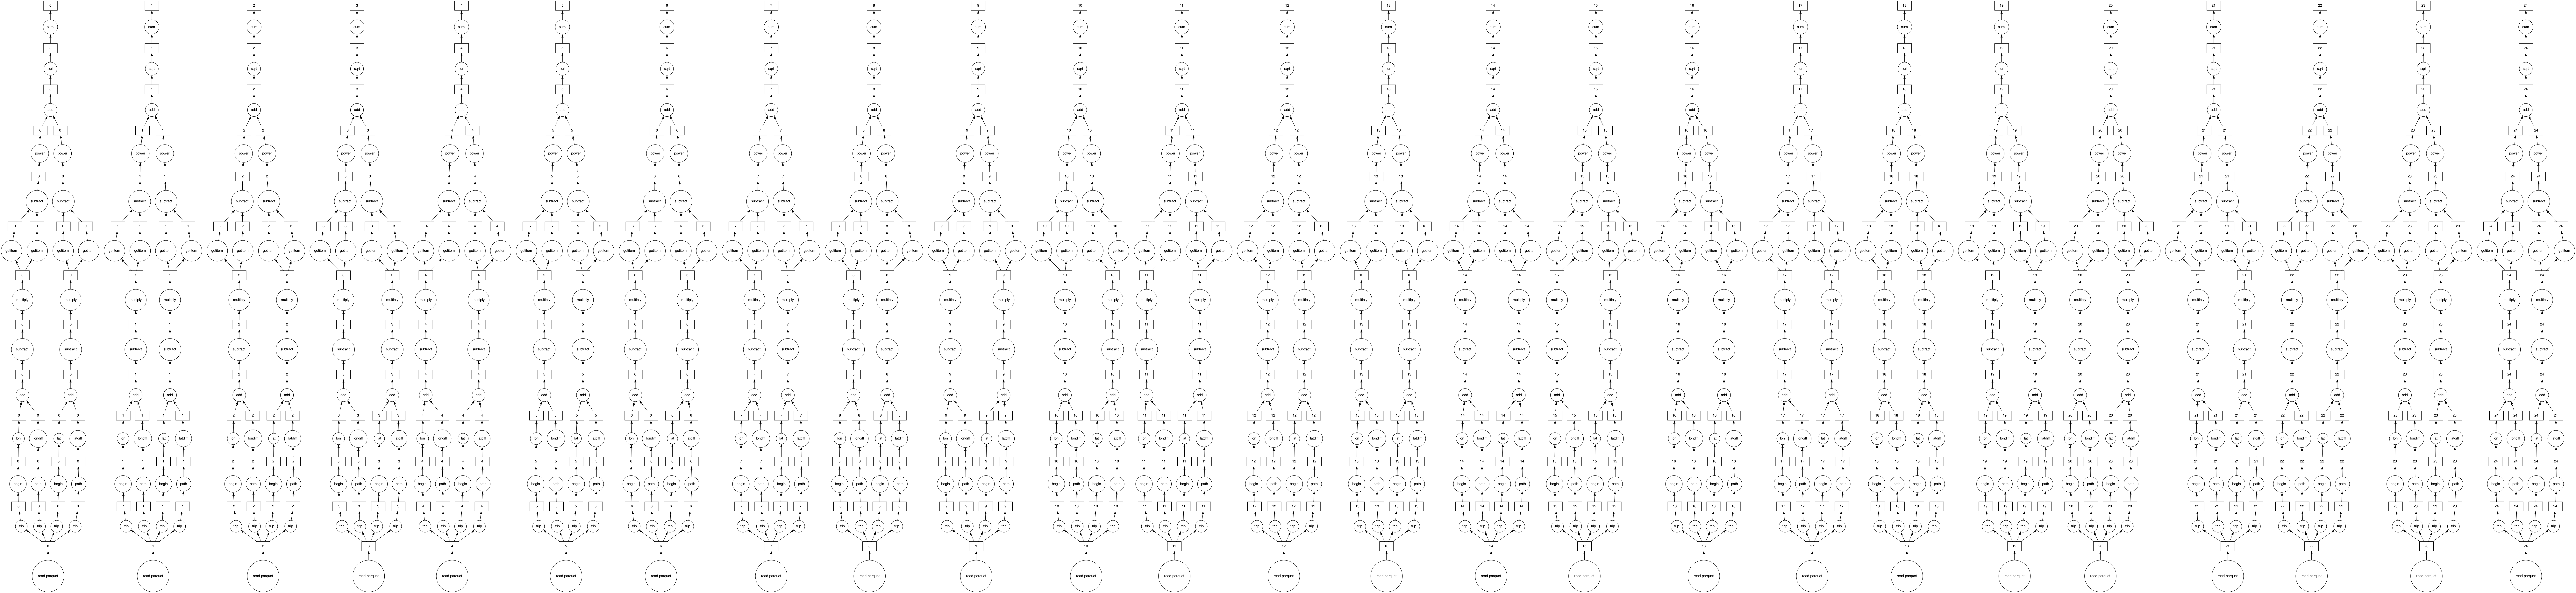

In [14]:
lengths.visualize()

In [15]:
import dask_histogram

h = dask_histogram.factory(
    dak.flatten(dak.fill_none(lengths, 0)),       # data to histogram along x-axis
    dak.flatten(dak.fill_none(taxi.trip.km, 0)),  # data to histogram along y-axis
    axes=(
        dask_histogram.axis.Regular(200, 0, 50),  # 200 bins from 0km to 50km
        dask_histogram.axis.Regular(200, 0, 50),
    ),
)

In [16]:
h.visualize()

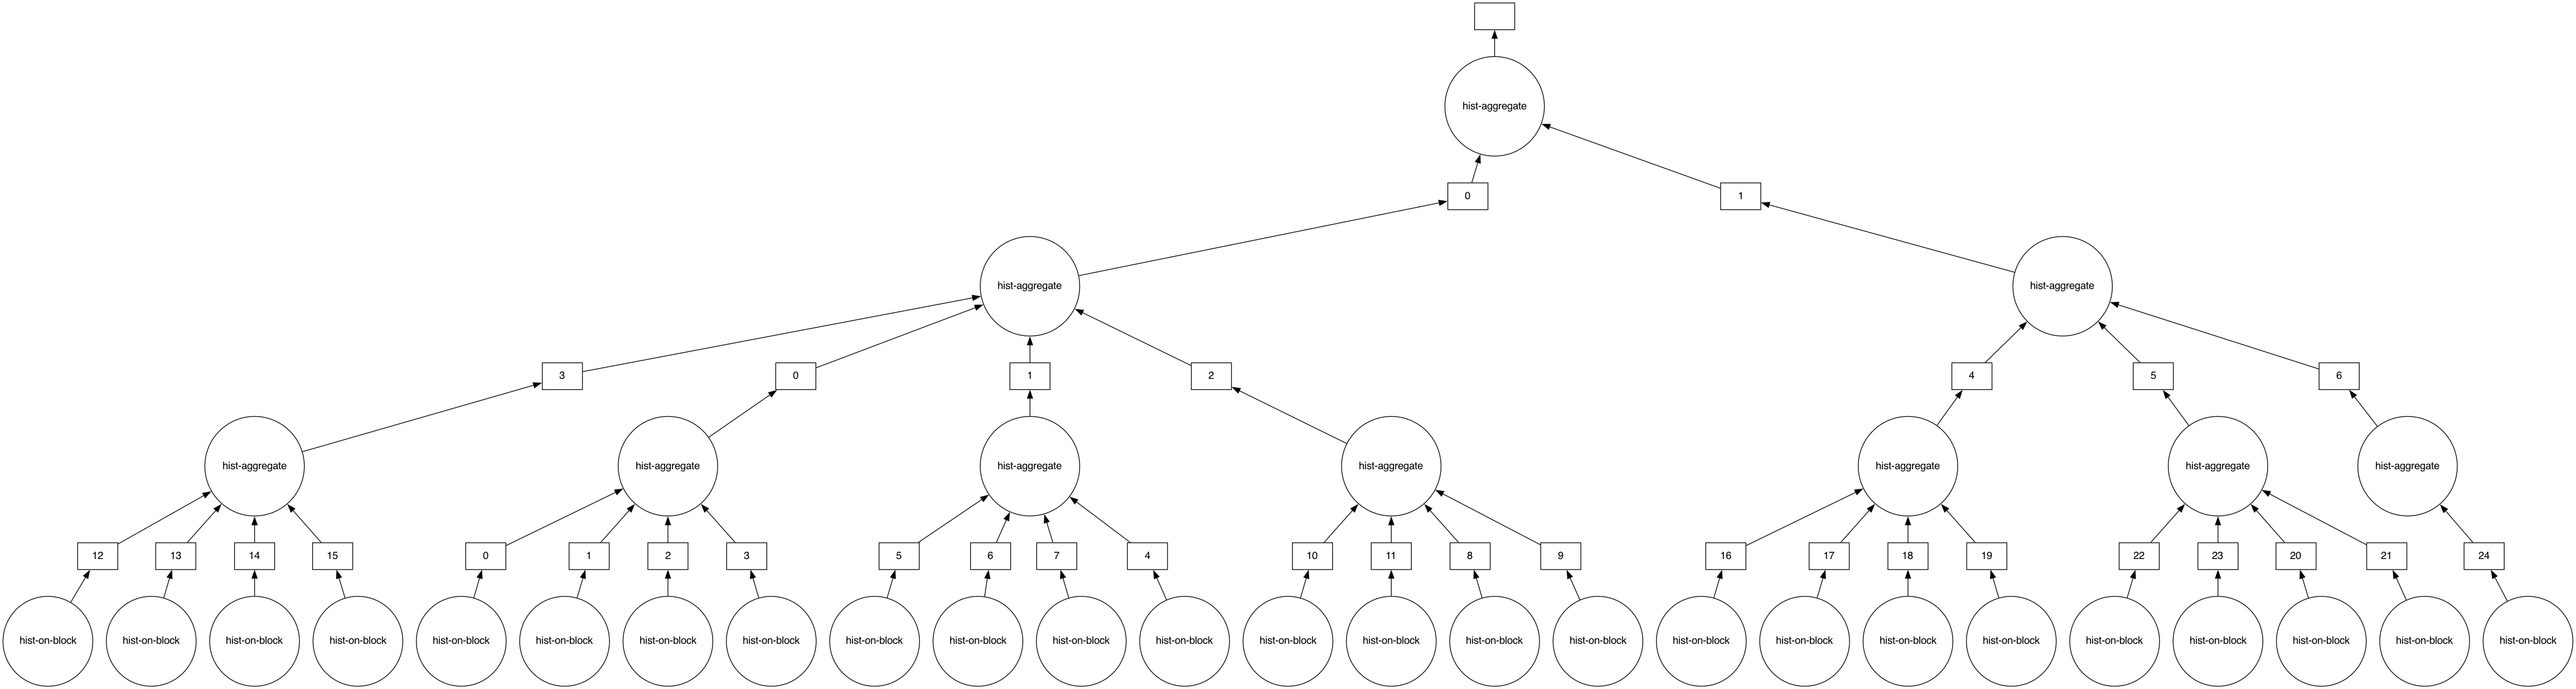

In [17]:
h.visualize(optimize_graph=True)

In [18]:
from dask.diagnostics import ProgressBar

In [19]:
with ProgressBar():
    h = h.compute()

[########################################] | 100% Completed | 17.76 s


Text(0, 0.5, 'Recorded distance')

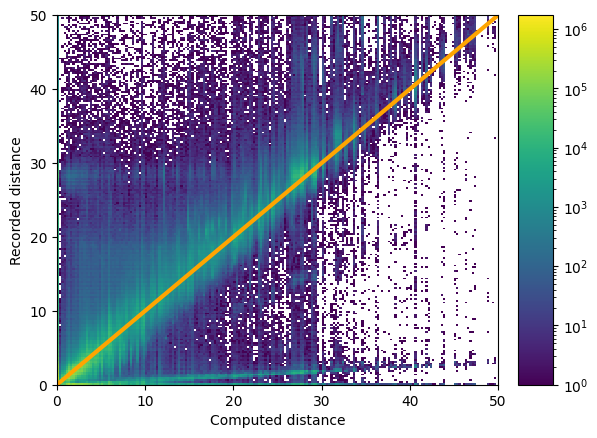

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import hist.plot

fig, ax = plt.subplots(1, 1)
hist.plot.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm())
ax.plot([0, 50], [0, 50], c="orange", lw=3);
ax.set_xlabel("Computed distance")
ax.set_ylabel("Recorded distance")